# Overview

In this notebook, we will fine-tune `facebook/bart-large-xsum` model on `SamSum` dataset.

Note: There is a technique we did not mentioned in the previously notebook. It is `transfer learning`, we can also call it `fine-tuning`.

# Evaluation Metrics

Evaluating performance for language models can be quite tricky, especially when it comes to text summarization. The goal of our model is to produce a short sentence describing the content of a dialogue, while maintaining all the important information within that dialogue.

One of the quantitative metrics we can employ to evaluate performance is the `ROUGE Score`. It is considered one of the best metrics for text summarization and it evaluates performance by comparing the quality of a machine-generated summary to a human generated summary used for reference.

The similarities between both summaries are measured by analyzing the overlapping `n-grams`, either single words of sequences of words that are present in both summaries. These can be unigrams(ROUGE-1), where only the overlap of sole words is measured; biggrams(ROUGE-2), where we measure the overlap of two-word sequencesl trigrams(ROUGE-3), where we measrure the overlap of three-word sequences; etc. Besides that, we also have:


**ROUGE-L**

It measures the *Longest Common Subsequence(LCS)* between the two summaries, which helps to capture content coverage of the machine-generated text. If both summaries have the sequence "the apple is green", we have a match regardless of where they appear in both texts.

**ROUGE-S**

It avaluates the overlap of skip-bigrams, which are bigrams that permit gaps between words. This helps to measure the coherence of a machine-generated summary. For example, in the phrase "this apple is absolutely green", we find a match for the terms such as "apple" and "green", if that is what we are looking for.

These scores might typically range from 0 to 100, where 0 indicates no match and 100 indicates a perfect match between both summaries. Besides quantitative metrics, it is useful to use `human evaluation` to analyze the output of language models, since we are able to comprehend text in a wat that a machine does not.



In [1]:
!nvidia-smi # Checking GPU

/bin/bash: nvidia-smi: command not found


In [2]:
%%capture --no-stderr
!pip install transformers==4.37.2
!pip install datasets==2.17.0
!pip install evaluate==0.4.1
!pip install rouge-score==0.1.2
# Installing library to save zip archives
!pip install py7zr==0.20.8


KeyboardInterrupt



In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# configuring Pandas to exhibit larger columns

import pandas as pd

pd.set_option('display.max_colwidth', 1000)

# Exploring the dataset

We are going to analyze each dataset separately.

In [4]:
train=pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-train.csv')
test=pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-test.csv')
val=pd.read_csv('/kaggle/input/samsum-dataset-text-summarization/samsum-validation.csv')
type(train)

pandas.core.frame.DataFrame

In [5]:
from IPython.display import display

def display_feature_list(features, feature_type):
    '''
    This function displays the features within each list for each type of data
    '''
    print(f'\n{feature_type} Features:')
    print(', '.join(features) if features else 'None')


def describe_dataframe(dataframe):
    global categorical_features, continuous_features, binary_features
    categorical_features=[col for col in dataframe.columns if dataframe[col].dtype=='object']
    binary_features=[col for col in dataframe.columns if dataframe[col].nunique() <=2 and dataframe[col].dtype!='object']
    continuous_features=[col for col in dataframe.columns if dataframe[col].dtype!='object' and col not in binary_features]
    
    print(f'\n{type(dataframe).__name__} shape: {dataframe.shape}')
    print(f'\n{dataframe.shape[0]:,.0f} samples')
    print(f'\n{dataframe.shape[1]:,.0f} attributes')
    print(f'\nMissing Data: \n{dataframe.isnull().sum()}')
    print(f'\nDuplicates:{dataframe.duplicated().sum()}')
    print(f'\nData types:\n{dataframe.dtypes}')
    
    display_feature_list(categorical_features, 'Categorical')
    display_feature_list(continuous_features, 'Continuous')
    display_feature_list(binary_features, 'Binary')
    
    print(f'\n{type(dataframe).__name__} Head: \n')
    display(dataframe.head(5))
    print(f'\n{type(dataframe).__name__} Tail: \n')
    display(dataframe.tail(5))


describe_dataframe(train)


DataFrame shape: (14732, 3)

14,732 samples

3 attributes

Missing Data: 
id          0
dialogue    1
summary     0
dtype: int64

Duplicates:0

Data types:
id          object
dialogue    object
summary     object
dtype: object

Categorical Features:
id, dialogue, summary

Continuous Features:
None

Binary Features:
None

DataFrame Head: 



,id,dialogue,summary
0,13818513,Amanda: I baked cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-),Amanda baked cookies and will bring Jerry some tomorrow.
1,13728867,Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great,Olivia and Olivier are voting for liberals in this election.
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",Kim may try the pomodoro technique recommended by Tim to get more stuff done.
3,13730747,"Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: Dont say anything else..\r\nEdward: What do you mean??\r\nrachel: Open your fu**ing door.. I'm outside",Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside.
4,13728094,"Sam: hey overheard rick say something\r\nSam: i don't know what to do :-/\r\nNaomi: what did he say??\r\nSam: he was talking on the phone with someone\r\nSam: i don't know who\r\nSam: and he was telling them that he wasn't very happy here\r\nNaomi: damn!!!\r\nSam: he was saying he doesn't like being my roommate\r\nNaomi: wow, how do you feel about it?\r\nSam: i thought i was a good rommate\r\nSam: and that we have a nice place\r\nNaomi: that's true man!!!\r\nNaomi: i used to love living with you before i moved in with me boyfriend\r\nNaomi: i don't know why he's saying that\r\nSam: what should i do???\r\nNaomi: honestly if it's bothering you that much you should talk to him\r\nNaomi: see what's going on\r\nSam: i don't want to get in any kind of confrontation though\r\nSam: maybe i'll just let it go\r\nSam: and see how it goes in the future\r\nNaomi: it's your choice sam\r\nNaomi: if i were you i would just talk to him and clear the air","Sam is confused, because he overheard Rick complaining about him as a roommate. Naomi thinks Sam should talk to Rick. Sam is not sure what to do."



DataFrame Tail: 



,id,dialogue,summary
14727,13863028,"Romeo: You are on my ‘People you may know’ list.\nGreta: Ah, maybe it is because of the changed number of somebody’s?\nGreta: I don’t know you?\nRomeo: This might be the beginning of a beautiful relationship\nRomeo: How about adding me on your friend list and talk a bit?\nGreta: No.\nRomeo: Okay I see.",Romeo is trying to get Greta to add him to her friend list but she refuses.
14728,13828570,"Theresa: <file_photo>\r\nTheresa: <file_photo>\r\nTheresa: Hey Louise, how are u?\r\nTheresa: This is my workplace, they always give us so much food here 😊\r\nTheresa: Luckily they also offer us yoga classes, so all the food isn't much of a problem 😂\r\nLouise: Hey!! 🙂 \r\nLouise: Wow, that's awesome, seems great 😎 Haha\r\nLouise: I'm good! Are you coming to visit Stockholm this summer? 🙂\r\nTheresa: I don't think so :/ I need to prepare for Uni.. I will probably attend a few lessons this winter\r\nLouise: Nice! Do you already know which classes you will attend?\r\nTheresa: Yes, it will be psychology :) I want to complete a few modules that I missed :)\r\nLouise: Very good! Is it at the Uni in Prague?\r\nTheresa: No, it will be in my home town :)\r\nLouise: I have so much work right now, but I will continue to work until the end of summer, then I'm also back to Uni, on the 26th September!\r\nTheresa: You must send me some pictures, so I can see where you live :) \r\nLouise: I will,...","Theresa is at work. She gets free food and free yoga classes. Theresa won't go to visit Louise in Stockholm, because she will prepare for university psychology lessons. She'll be back at uni on 26th September."
14729,13819050,"John: Every day some bad news. Japan will hunt whales again\r\nErica: Yes, I've read this. It's very upsetting\r\nJohn: Cruel Japanese\r\nFaith: I think this is a racist remark. Because Island and Norways has never joined this international whaling agreement\r\nErica: really? I haven't known, everybody is so outraged by Japan\r\nFaith: sure, European hypocrisy \r\nJohn: not entirely. Scandinavians don't use the nets that Japanese use, so Norway and Island kill much less specimens that Japan will\r\nFaith: oh, it's much more complex than one may expect\r\nJohn: True, but the truth is, that all of them should stop\r\nJohn: and this decision is a step back\r\nFaith: yes, this is worrying\r\nErica: And it seems that the most important whaling countries are out of the agreement right now\r\nFaith: yes, seems so\r\nJohn: Just like USA leaving the Paris Agreement",Japan is going to hunt whales again. Island and Norway never stopped hunting them. The Scandinavians kill fewer whales than the Japanese.
14730,13828395,"Jennifer: Dear Celia! How are you doing?\r\nJennifer: The afternoon with the Collins was very pleasant, nice folks, but we missed you.\r\nJennifer: But I appreciate your consideration for Peter.\r\nCelia: My dear Jenny! It turns out that my decision not to come, though I wanted so much to see you again and Peter and the Collins, was right. Yesterday it all developed into a full bore cold. Sh.....\r\nCelia: All symptoms like in a text book.\r\nCelia: Luckily it's contagious only on the first 2, 3 days, so when we meet next week it should be alright.\r\nCelia: Thanks for asking! Somehow for all of us Peter comes first now.\r\nJennifer: That's too bad. Poor you...\r\nJennifer: I'll be driving to FR, do you want me to bring you sth? It's on my way.\r\nCelia: Thank you dear! I was at the pharmacy yesterday and had done my shopping the day before.\r\nCelia: You'd better still stay away from me in case I'm still contagious\r\nJennifer: Right. So I'll only leave a basket on your terrace. A...","Celia couldn't make it to the afternoon with the Collins and Jennifer as she is ill. She's working, but doesn't want to meet with Jennifer as it might be contagious. Jennifer will leave a basket with cookies on Celia's terrace."
14731,13729017,"Georgia: are you ready for hotel hunting? We need to book somethin

## Dealing with blank values


In [6]:
mask=train['dialogue'].isnull() # crating mask with null dialogues
filtered_train=train[mask] # filtering dataframe
filtered_train

,id,dialogue,summary
6054,13828807,NaN,problem with visualization of the content


In [7]:
# removing it
train=train.dropna()

# removing Id from categorical features list
categorical_features.remove('id')

## Analyzing the length of both dialogues and summaries

We do the analyzation by counting the words in the. This might give us a clue about how these texts are structed.

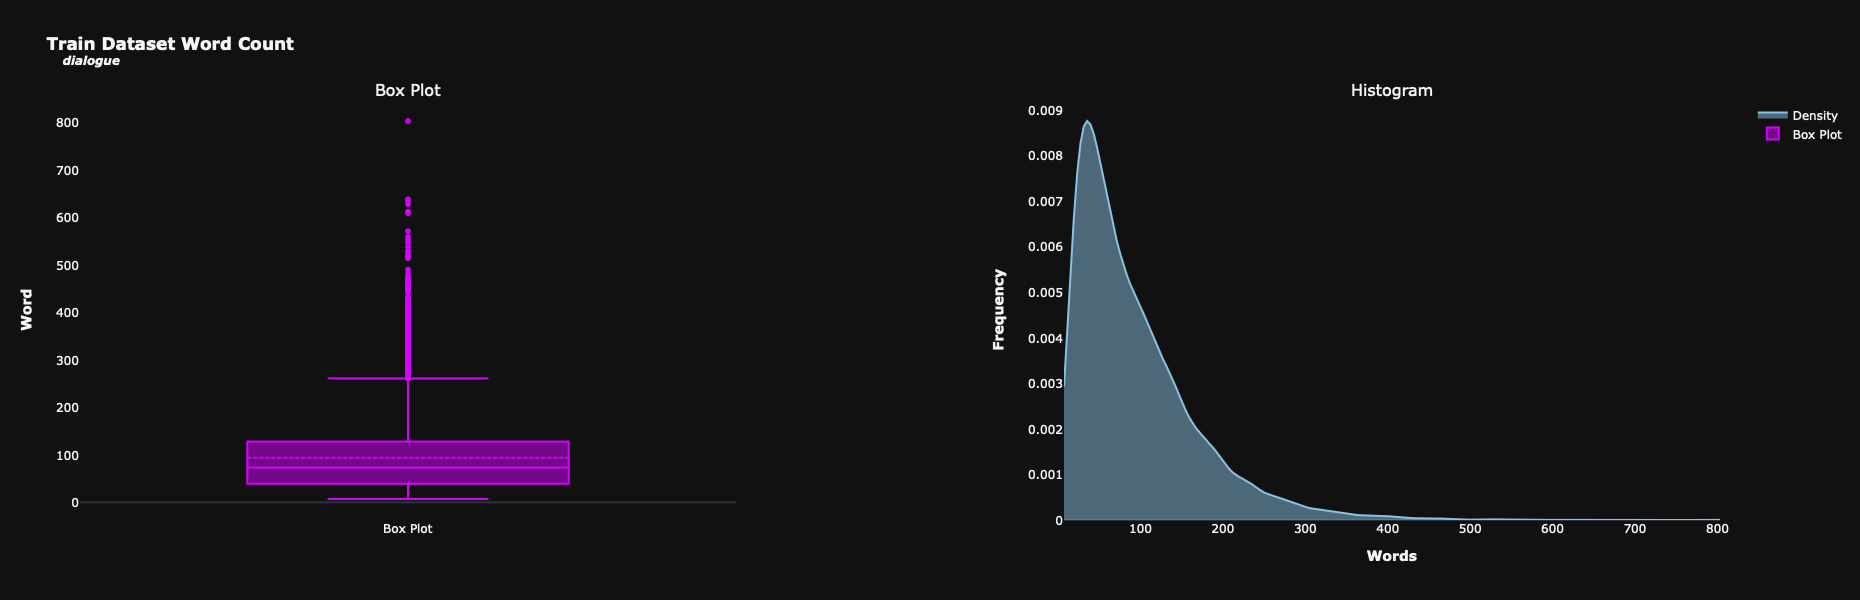

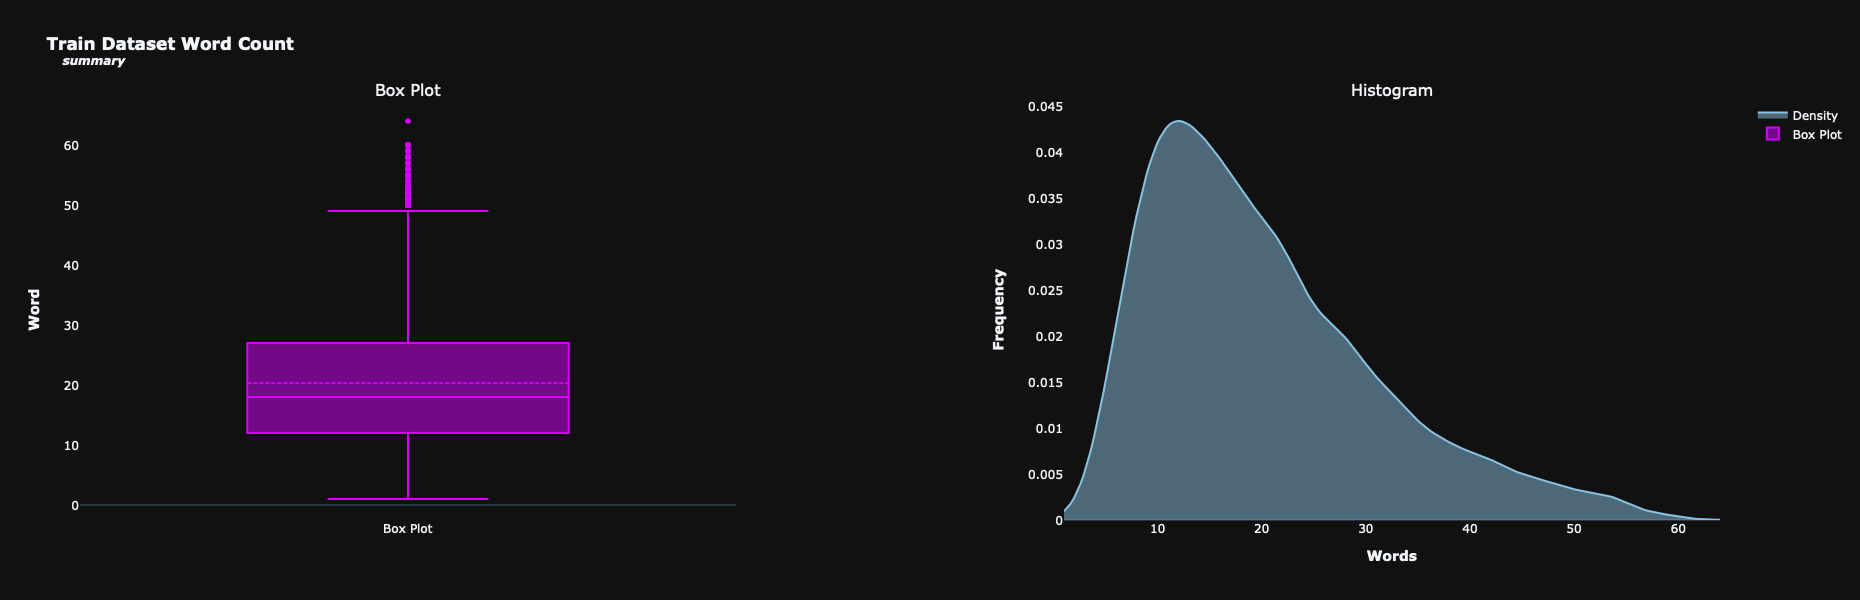

In [10]:
# Data Visualization
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
from scipy.stats import gaussian_kde

# paper_color=
# bg_color =

template='plotly_dark'

def histogram_boxplot(df, hist_color, box_color, height, width, legend, name):
    '''This function plots a Histogram and a Box plot side by side
    
    Parameters:
    * hist_color: the color of the histogram
    * box_color: the color of the boxplots
    * heigh and width: Image size
    * legend = Either to display legend or not
    '''
    
    features=df.select_dtypes(include=[np.number]).columns.tolist()
    
    for feat in features:
        try:
            fig=make_subplots(rows=1, cols=2, subplot_titles=['Box Plot', 'Histogram'], horizontal_spacing=0.2)
            density=gaussian_kde(df[feat])
            x_vals=np.linspace(min(df[feat]), max(df[feat]), 200)
            density_vals=density(x_vals)
            
            fig.add_trace(go.Scatter(x=x_vals, y=density_vals, mode='lines', fill='tozeroy', name='Density', line_color=hist_color), row=1, col=2)
            fig.add_trace(go.Box(y=df[feat], name='Box Plot', boxmean=True, line_color=box_color), row=1, col=1)
            fig.update_layout(title={'text':f'<b>{name} Word Count<br><sup><i>&nbsp;&nbsp;&nbsp;&nbsp;{feat}</i></sup></b>', 'x':.025, 'xanchor':'left'}, 
                              margin=dict(t=100),
                              showlegend=legend, 
                              template=template,
                              #plot_bgcolor=bg_color,
                              #paper_bgcolor=paper_color,
                              height=height,
                              width=width,
                             )
            fig.update_yaxes(title_text=f'<b>Word</b>', row=1, col=1, showgrid=False)
            fig.update_xaxes(title_text='', row=1, col=1, showgrid=False)
            fig.update_yaxes(title_text='<b>Frequency</b>', row=1, col=2, showgrid=False)
            fig.update_xaxes(title_text=f'<b>Words</b>', row=1, col=2, showgrid=False)
            
            fig.show()
            print('\n')
        except Exception as e:
            print(f'An error occurred: {e}')
            
    
    
df_text_length=pd.DataFrame() # crating an empty dataframe
for feat in categorical_features: # iterating through features --> dialogue & summary
    df_text_length[feat]=train[feat].apply(lambda x: len(str(x).split())) # counting words for each feature

# ploting histogram-boxplot
histogram_boxplot(df_text_length, '#89c2e0', '#d500ff', 600, 1000, True, 'Train Dataset')

From the result above, dialogues consist of about 94 words. we do have some outliers with very extensive texts, going way over 300 words per dialogue. Summaries are naturally shorters texts, consisting of about 20 words on average, although we also have some outliers with extensive summaries.


## Investigating more

We can also use scikit-learn's `TfidfVectorizer` to extarct more infor on the dialogues and summaries available. This function will give us a dataframe with the top n most frequent terms in the corpus, which we select by using the `max_features` parameter.

In this dataframe, each column represents the $n$ most frequent terms in the overall corpus, while each row represents one entry in the original dataframe, such as `train`. For each term in each entry we will see the TF-IDF score associated with it, which quantifies the relevance of a term in a given dialogue - or summary - relative to its frequency across all other dialogues - or summaries. We will also use the `bgram_range` parameter to select the mosr frequent words(unigrams), the most frequent sequence of two words(bigrams), and the most frequent sequence of three words(trigrams). The `stop_words='english'` parameter will help us filter out common stop-words of the English language, which are words that do not add up much to the overall context, such as "and", "of", etc. After measuring the most frequent terms, we will plot

# Credit

* https://www.kaggle.com/code/lusfernandotorres/text-summarization-with-large-language-models/notebook